<a href="https://colab.research.google.com/github/vusanov/madmodel/blob/main/Hanoi_housing_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load The Initial Dataset**

In [390]:
from google.colab import files
uploaded = files.upload()

Saving Hanoi_housing_dataset.csv to Hanoi_housing_dataset (1).csv


# **Import Necessary Libraries**

In [391]:
import time
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import pandas as pd
import scipy
from scipy.linalg import null_space
import matplotlib.pyplot as plt
from sympy import Rational
import sympy as sp
import random
from sklearn.preprocessing import StandardScaler

# **Pre-Processing Dataset Stage**

In [392]:
df = pd.read_csv("Hanoi_housing_dataset.csv")
df["Ngày"] = pd.to_datetime(df["Ngày"])
df["Ngày"].dt.year.value_counts()
df["Ngày"] = df["Ngày"].astype(str)

In [393]:
df = df.rename(columns = {"Ngày":"date", "Địa chỉ":"address", "Quận":"district",
                                  "Huyện":"ward", "Loại hình nhà ở":"type_of_housing",
                                 "Giấy tờ pháp lý":"legal_paper", "Số tầng":"num_floors",
                                 "Số phòng ngủ":"num_bed_rooms", "Diện tích":"squared_meter_area",
                                 "Dài":"length_meter", "Rộng":"width_meter", "Giá/m2":"price_in_million_per_square_meter"})

In [394]:
df = df.drop("Unnamed: 0", axis = 1)
df = df.dropna()
df = df.reset_index()

print("The total records of the dataset are: ", str(len(df)), "records.")

The total records of the dataset are:  11473 records.


In [395]:
df = df[df['num_floors'] != 'Nhiều hơn 10']
df = df[df['num_bed_rooms'] != 'nhiều hơn 10 phòng']

In [396]:
df['district'] = df['district'].str.replace('Quận ','').str.strip()
df['ward'] = df['ward'].str.replace('Phường ','').str.strip()
df['num_floors'] = df['num_floors'].str.strip().astype(float)
df['num_bed_rooms'] = df['num_bed_rooms'].str.replace(' phòng','').str.strip().astype(float)
df['squared_meter_area'] = df['squared_meter_area'].str.replace(' m²','').str.strip().astype(float)
df['length_meter'] = df['length_meter'].str.replace(' m','').str.strip().astype(float)
df['width_meter'] = df['width_meter'].str.replace(' m','').str.strip().astype(float)

In [397]:
df.loc[df['price_in_million_per_square_meter'].str.contains(' tỷ/m²'), 'price_in_million_per_square_meter'] = df.loc[df['price_in_million_per_square_meter'].str.contains(' tỷ/m²'), 'price_in_million_per_square_meter'].str.replace(' tỷ/m²','').str.replace('.','').str.replace(',','.').astype(float) * 1000
df.loc[df['price_in_million_per_square_meter'].str.contains(' triệu/m²', na=False), 'price_in_million_per_square_meter'] = df.loc[df['price_in_million_per_square_meter'].str.contains(' triệu/m²', na=False), 'price_in_million_per_square_meter'].str.replace(' triệu/m²','').str.replace(',','.').astype(float)
df.loc[df['price_in_million_per_square_meter'].str.contains(' đ/m²', na=False), 'price_in_million_per_square_meter'] = df.loc[df['price_in_million_per_square_meter'].str.contains(' đ/m²', na=False), 'price_in_million_per_square_meter'].str.replace(' đ/m²','').str.replace('.','').astype(float) * 0.000001

In [398]:
# Use One-hot encoding to classify features such as "Loại nhà ở", "Giấy tờ pháp lý", "Quận", "Huyện"

dummy_type_of_housing = pd.get_dummies(df.type_of_housing, prefix="housing_type")
dummy_legal_paper = pd.get_dummies(df.legal_paper, prefix="legal_paper")
dummy_district = pd.get_dummies(df.district, prefix="district")
dummy_ward = pd.get_dummies(df.ward, prefix="ward")

df_cleaned = pd.concat([df, dummy_type_of_housing, dummy_legal_paper, dummy_district, dummy_ward], axis=1)
df_cleaned = df_cleaned.drop(['index', 'date', 'address', 'district', 'ward', 'type_of_housing', 'legal_paper'], axis = 1)

In [399]:
# Remove outlier values

def remove_outlier_IQR(df, series):
    Q1=df[series].quantile(0.25)
    Q3=df[series].quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df[series]<(Q1-1.5*IQR)) | (df[series]>(Q3+1.5*IQR)))]
    return df_final

removed_outliers = df_cleaned
columns_to_remove_outliers = ['num_floors', 'num_bed_rooms', 'squared_meter_area', 'length_meter',
                              'width_meter', 'price_in_million_per_square_meter']
for column in columns_to_remove_outliers:
    removed_outliers = remove_outlier_IQR(removed_outliers, column)

print("The final length of the dataset is", str(len(removed_outliers)), "rows.")

The final length of the dataset is 7328 rows.


In [400]:
data = removed_outliers

# **Split The Hanlded Data Into Training, Testing Set And Normalize them using StandardScaler**

In [401]:
n = int(0.8*len(data))
x = data.loc[:, (data.columns != 'price_in_million_per_square_meter') & (data.columns != 'date')]
y = data[['price_in_million_per_square_meter']]
to_be_scaled = ['num_floors', 'num_bed_rooms', 'squared_meter_area', 'length_meter', 'width_meter']

PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()

x_scaled = x
y_scaled = y

# Storing the fit object for reference and reverse the scaling later
PredictorScalerFit=PredictorScaler.fit(x_scaled[to_be_scaled])
TargetVarScalerFit=TargetVarScaler.fit(y_scaled)

x_scaled[to_be_scaled]=PredictorScalerFit.transform(x_scaled[to_be_scaled])
y_scaled=TargetVarScalerFit.transform(y)

x_arr = np.array(x_scaled.values).astype("float32")
y_arr = np.array(y_scaled).astype("float32")

xtr, ytr = torch.tensor(x_arr[:n], dtype=torch.float32), torch.tensor(y_arr[:n], dtype=torch.float32)
xte, yte = torch.tensor(x_arr[n:], dtype=torch.float32), torch.tensor(y_arr[n:], dtype=torch.float32)
print((xtr.shape, ytr.shape), (xte.shape, yte.shape))

(torch.Size([5862, 280]), torch.Size([5862, 1])) (torch.Size([1466, 280]), torch.Size([1466, 1]))


/tmp/ipython-input-1111104033.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_scaled[to_be_scaled]=PredictorScalerFit.transform(x_scaled[to_be_scaled])


# **Build The Model And Necessary Technique Layers**

In [402]:
# CosineAnnealingLR method for controlling learning rate during each training step
class CosineAnnealingLR:
  def __init__(self, initial_lr, max_steps, min_lr=1e-6):
    self.initial_lr = initial_lr
    self.max_steps = max_steps
    self.min_lr = min_lr

  def get_lr(self, current_step):
    curr = (1 + torch.cos(torch.pi * current_step / self.max_steps)) / 2
    return self.min_lr + (self.initial_lr - self.min_lr) * curr

# Linear class
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) * (2**0.5) / ((fan_in)**0.5)
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# Batch normalization technique
class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.gamma = torch.ones(dim) #- 0.70
    self.beta = torch.zeros(dim)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# Tanh activation function
class tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# ReLU activation function
class relu:
  def __call__(self, x):
    self.out = torch.relu(x)
    return self.out
  def parameters(self):
    return []

# GELU activation function
class gelu:
  def __call__(self, x):
    self.out =  0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) *(x + 0.044715 * torch.pow(x, 3))))
    return self.out
  def parameters(self):
    return []

# Residual Connection layer to avoid vanishing-gradient phenomenon during backpropagation process
class ResidualLayer:
  def __init__(self, block):
    self.block = block
    self.out = None

  def __call__(self, x):
    identity = x
    out_temp = x
    for layer in self.block:
      out_temp = layer(out_temp)
    self.out = out_temp + identity
    return self.out

  def parameters(self):
    return [p for layer in self.block for p in layer.parameters()]

# **Initialize The Model And Related Configurations**

In [403]:
input = xtr.shape[1]
output = 1
n_hidden = 32 # The amount of neurons in hidden layers
mae_loss = nn.L1Loss() # Correspond to the mean absolute error (MAE)
g = torch.Generator().manual_seed(2147483647) # Reproducibility

# The model
layers = [
   Linear(input, n_hidden, bias=False), relu(),
   ResidualLayer([Linear(n_hidden, n_hidden, bias=False), relu()]),
   Linear(n_hidden, n_hidden, bias=False), relu(),
   ResidualLayer([Linear(n_hidden, n_hidden, bias=False), relu()]),
   Linear(n_hidden, output, bias=False),
]

'''layers = [
   Linear(input, n_hidden, bias=False), BatchNorm1d(n_hidden), relu(),
   ResidualLayer([Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), relu()]),
   Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), relu(),
   ResidualLayer([Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), relu()]),
   Linear(n_hidden, output, bias=False),
]'''

# Store all model parameters and set 'requires_grad = True' for turning them into trainable weights during training
parameters = [p for layer in layers for p in layer.parameters()]
print(np.sum([p.nelement() for p in parameters]))
for p in parameters:
  p.requires_grad = True

12064


In [404]:
# Create this function for taking all sub-layers that inside the Residual Connection layer
def get_all_layers(layers_list):
  expanded_list = []
  for layer in layers_list:
    expanded_list.append(layer)
    if hasattr(layer, 'block'):
      expanded_list.extend(get_all_layers(layer.block))
  return expanded_list

In [405]:
print(get_all_layers(layers))

[<__main__.Linear object at 0x7c66786d97f0>, <__main__.relu object at 0x7c66786d9700>, <__main__.ResidualLayer object at 0x7c66802a1700>, <__main__.Linear object at 0x7c66802a14c0>, <__main__.relu object at 0x7c66802a2180>, <__main__.Linear object at 0x7c66802a1460>, <__main__.relu object at 0x7c66802a0e00>, <__main__.ResidualLayer object at 0x7c66802a20f0>, <__main__.Linear object at 0x7c66802a13a0>, <__main__.relu object at 0x7c66802a21b0>, <__main__.Linear object at 0x7c66802a2150>]


In [406]:
# Try making predictions with the model before training
out = xtr
for layer in layers:
  out = layer(out)

y_pred = TargetVarScalerFit.inverse_transform(out.detach())
ytr_orig = TargetVarScalerFit.inverse_transform(ytr)

# Display predicted results using Pandas
TestingData = pd.DataFrame(data=xtr, columns=x.columns)
TestingData['Truth label'] = ytr_orig
TestingData['Predicted label'] = y_pred
TestingData[['Truth label', 'Predicted label']][:5]

,Truth label,Predicted label
0,65.000000,90.945283
1,93.270000,94.796534
2,60.940001,80.431433
3,29.759997,51.125805
4,49.999999,98.657474


# **Training Stage**

In [407]:
max_steps = 100000
batch_size = 128
initial_lr = 0.1 # I'll set initial lr = 0.1 and gradually reduce lr according to the Cosine function curve.
all_layers_flat = get_all_layers(layers)
scheduler = CosineAnnealingLR(initial_lr=initial_lr, max_steps=torch.tensor(max_steps, dtype=torch.float32)) # Initialize CosineAnnealingLR

for i in range(max_steps):

  # minibatch construct if we use Batch Normalization technique, other wise, just using the original xtr, ytr
  #idx = torch.randint(0, xtr.shape[0], (batch_size,), generator=g)
  #Xb, Yb = xtr[idx], ytr[idx] # batch X,Y

  # forward pass
  out = xtr
  for layer in layers:
    out = layer(out)
  y_pred = out
  loss = mae_loss(y_pred, ytr.reshape(-1, 1)) # loss function

  # backward pass
  for layer in all_layers_flat:
    if hasattr(layer, 'out') and layer.out is not None:
      layer.out.retain_grad() # Get the gradient in all layers (include all sub-layers of the Residual layers) for drawing the gradient graph

  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = 0.1 if i < 5000 else 0.01 # step learning rate decay
  lr = scheduler.get_lr(i)
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0 or i == 99999:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f} | lr: {lr}')
  #break

      0/ 100000: 0.8913 | lr: 0.10000000149011612
  10000/ 100000: 0.3044 | lr: 0.09755285084247589
  20000/ 100000: 0.2276 | lr: 0.0904509425163269
  30000/ 100000: 0.2164 | lr: 0.07938946783542633
  40000/ 100000: 0.1910 | lr: 0.06545119732618332
  50000/ 100000: 0.1654 | lr: 0.05000050738453865
  60000/ 100000: 0.1283 | lr: 0.03454980626702309
  70000/ 100000: 0.1084 | lr: 0.020611535757780075
  80000/ 100000: 0.0930 | lr: 0.009550061076879501
  90000/ 100000: 0.0831 | lr: 0.0024481515865772963
  99999/ 100000: 0.0808 | lr: 9.999999974752427e-07


In [408]:
# All experiments with different techniques

#100000 loops (with 1 ReLU() layer, n_hidden=15, lr=0.1, He init) -> error: 0.3652
#100000 loops (with 1 ReLU() layer, n_hidden=32, lr=0.1, He init) -> error: 0.2901
#100000 loops (with 2 ReLU() layers, n_hidden=15, lr=0.1, He init) -> error: 0.3112
#100000 loops (with 2 ReLU() layers, n_hidden=32, lr=0.1, He init) -> error: 0.1701

#100000 loops (with 1 ReLU() layer, 1 Residual layer, n_hidden=15, lr=0.1, He init) -> error: 0.3193
#100000 loops (with 1 ReLU() layer, 1 Residual layer, n_hidden=32, lr=0.1, He init) -> error: 0.1695
#100000 loops (with 2 ReLU() layer, 2 Residual layer, n_hidden=15, lr=0.1, He init) -> error: 0.2658
#100000 loops (with 2 ReLU() layer, 2 Residual layer, n_hidden=32, lr=0.1, He init) -> error: 0.0808

# Note: For Batch Normalization, i think we should use fixed learning rate due to its noise through batches, but i still use consineLR due to my laziness
#100000 loops (with 1 ReLU() layer, 1 Batchnorm layer (64 batches), n_hidden=15, lr=0.1, He init) -> error: 0.47256 (mean)
#100000 loops (with 1 ReLU() layer, 1 Batchnorm layer (64 batches), n_hidden=32, lr=0.1, He init) -> error: 0.44763 (mean)
#100000 loops (with 1 ReLU() layer, 1 Batchnorm layer (128 batches), n_hidden=15, lr=0.1, He init) -> error: 0.44629 (mean)
#100000 loops (with 1 ReLU() layer, 1 Batchnorm layer (128 batches), n_hidden=32, lr=0.1, He init) -> error: 0.39471 (mean)
#100000 loops (with 2 ReLU() layer, 2 Batchnorm layer (64 batches), n_hidden=15, lr=0.1, He init) -> error: 0.49454 (mean)
#100000 loops (with 2 ReLU() layer, 2 Batchnorm layer (64 batches), n_hidden=32, lr=0.1, He init) -> error: 0.40521 (mean)
#100000 loops (with 2 ReLU() layer, 2 Batchnorm layer (128 batches), n_hidden=15, lr=0.1, He init) -> error: 0.46335 (mean)
#100000 loops (with 2 ReLU() layer, 2 Batchnorm layer (128 batches), n_hidden=32, lr=0.1, He init) -> error: 0.37837 (mean)

#100000 loops (with 1 ReLU() layer, 1 Batchnorm layer (128 batches), 1 Residual layer, n_hidden=15, lr=0.1, He init) -> error: 0.52095 (mean)
#100000 loops (with 1 ReLU() layer, 1 Batchnorm layer (128 batches), 1 Residual layer, n_hidden=32, lr=0.1, He init) -> error: 0.40776 (mean)
#100000 loops (with 2 ReLU() layer, 2 Batchnorm layer (128 batches), 2 Residual layer, n_hidden=15, lr=0.1, He init) -> error: 0.47726 (mean)
#100000 loops (with 2 ReLU() layer, 2 Batchnorm layer (128 batches), 2 Residual layer, n_hidden=32, lr=0.1, He init) -> error: 0.34930 (mean)

# **Visualize Gradients And Outputs Of All Layers**

layer 0 (    Linear): mean -0.000000, std 2.165664e-04
layer 1 (      relu): mean +0.000001, std 4.472245e-04
layer 2 (ResidualLayer): mean -0.000000, std 2.791185e-04
layer 3 (    Linear): mean +0.000000, std 1.223755e-04
layer 4 (      relu): mean -0.000000, std 2.293959e-04
layer 5 (ResidualLayer): mean -0.000000, std 1.530839e-04
layer 6 (    Linear): mean +0.000000, std 1.699632e-04


Text(0.5, 1.0, 'gradient distribution')

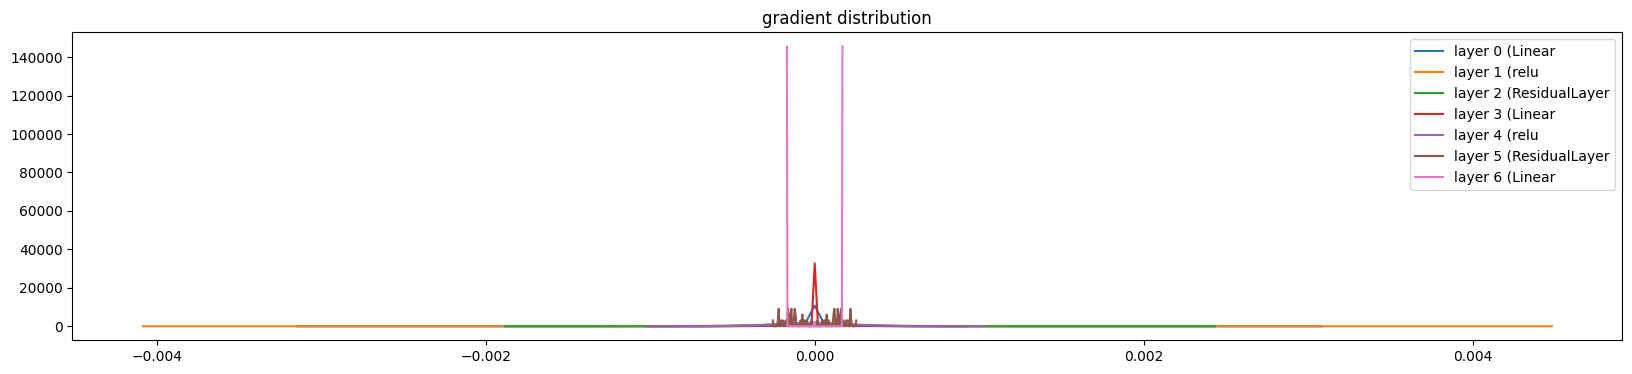

In [409]:
# Gradient distribution through all layers after 100000 loops
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:]):
  t = layer.out.grad
  print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
  hy, hx = torch.histogram(t, density=True)
  plt.plot(hx[:-1].detach(), hy.detach())
  legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

In [410]:
# Print the gradients of all Linear layers
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Linear):
    t = layer.out.grad
    print(t.min(), t.max())
    print(t)

tensor(-0.0031) tensor(0.0031)
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          2.5119e-04,  0.0000e+00],
        [-5.9966e-04,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          4.0783e-05,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0927e-03,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  3.5676e-04,  ...,  0.0000e+00,
         -3.7061e-04,  0.0000e+00],
        [ 1.0744e-04,  0.0000e+00,  4.7474e-04,  ..., -8.8707e-05,
          2.8764e-04, -2.3595e-04]])
tensor(-0.0010) tensor(0.0009)
tensor([[ 0.0000e+00,  0.0000e+00, -3.1472e-05,  ...,  0.0000e+00,
          0.0000e+00, -1.4917e-04],
        [-7.6838e-05,  1.8413e-04,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -2.0417e-04,  0.0000e+00

layer 1 (      relu): mean +0.00, std 0.00, saturated: 0.00%
layer 4 (      relu): mean -0.00, std 0.00, saturated: 0.00%


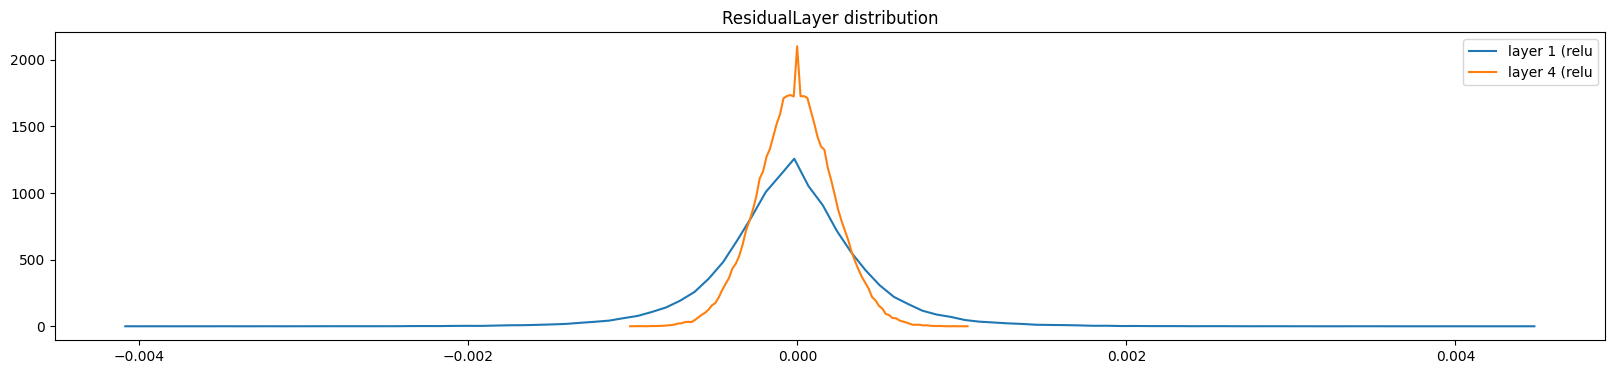

In [411]:
# All ReLU layers' gradient distribution through after 100000 loops
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, relu):
    t = layer.out.grad
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
  plt.legend(legends);
  plt.title(f'{layer.__class__.__name__} distribution')

layer 1 (      relu): mean +0.13, std 0.25, saturated: 1.68%
layer 4 (      relu): mean +0.15, std 0.28, saturated: 2.36%


Text(0.5, 1.0, 'Linear distribution')

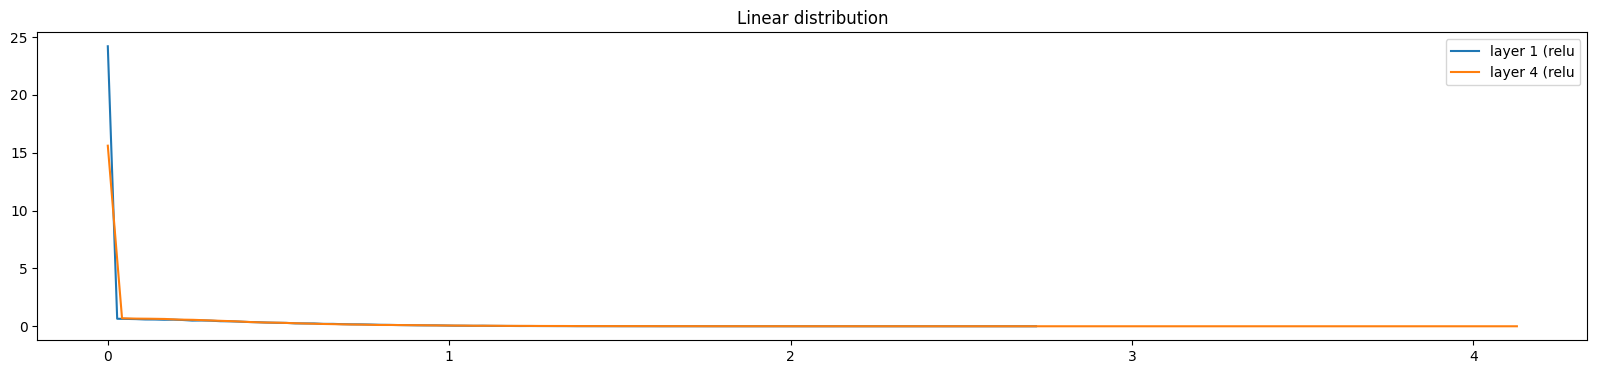

In [412]:
# All ReLU layers' output distribution through after 100000 loops - so bad T_T
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, relu):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('Linear distribution')

Text(0.5, 1.0, 'BatchNorm distribution')

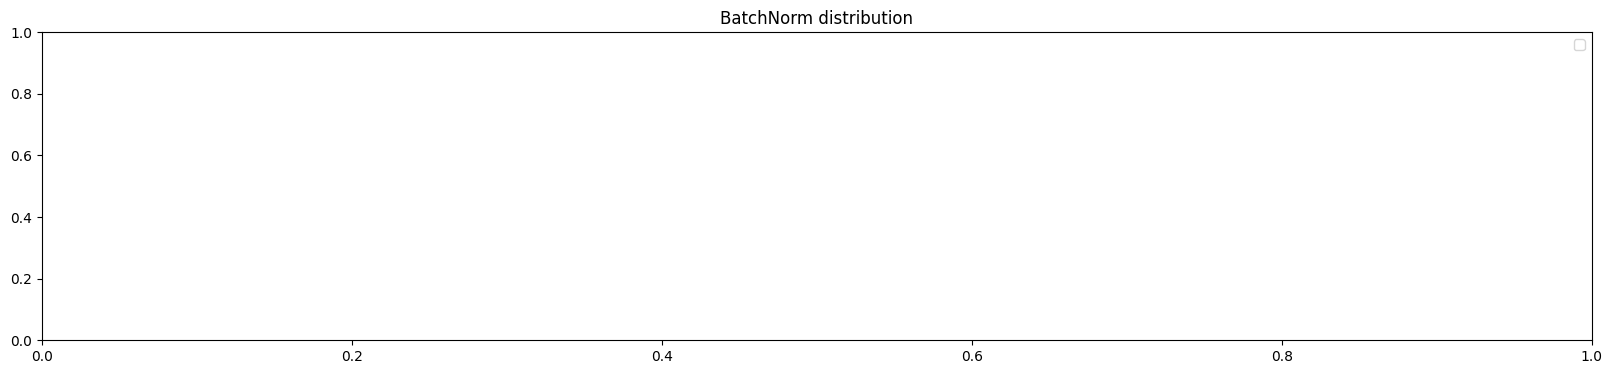

In [413]:
# All Batchnorm layers' output distribution through after 100000 loops
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, BatchNorm1d):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('BatchNorm distribution')

# **Making Predictions**

In [414]:
# Try making predictions on the training set with trained model
for layer in layers:
  layer.training = False

out = xtr
for layer in layers:
  out = layer(out)

y_pred = TargetVarScalerFit.inverse_transform(out.detach())
ytr_orig = TargetVarScalerFit.inverse_transform(ytr)

TestingData = pd.DataFrame(data=xtr, columns=x.columns)
TestingData['Truth label'] = ytr_orig
TestingData['Predicted label'] = y_pred
TestingData[['Truth label', 'Predicted label']][:10]

,Truth label,Predicted label
0,65.000000,64.999996
1,93.270000,93.378301
2,60.940001,60.940013
3,29.759997,29.760195
4,49.999999,50.000064
5,68.420001,94.455205
6,82.670000,85.493818
7,105.560000,105.559760
8,136.360000,138.950556
9,89.060000,89.061145


In [415]:
# Try making predictions on the testing set with trained model - maybe it's a bit overfitting T_T
for layer in layers:
  layer.training = False

out = xte
for layer in layers:
  out = layer(out)

y_pred = TargetVarScalerFit.inverse_transform(out.detach())
yte_orig = TargetVarScalerFit.inverse_transform(yte)

TestingData = pd.DataFrame(data=xte, columns=x.columns)
TestingData['Truth label'] = yte_orig
TestingData['Predicted label'] = y_pred
TestingData[['Truth label', 'Predicted label']][:10]

,Truth label,Predicted label
0,103.330000,56.919263
1,54.330000,54.320515
2,85.710000,103.436263
3,100.000000,73.631388
4,95.000000,79.271975
5,77.140000,83.269607
6,32.859999,36.848669
7,124.240001,85.591364
8,133.330001,103.466963
9,90.480000,124.041112
